COPY FROM t1 FOLDER: change input to have time-dependency and add LSTM model

Search for "FIXME" for tunable parameters

Results summary for data2 (i.e. white noise and inverse):
- PCA: successfully identifies the single common component
- AE-15: MSE 1.3%
- AE-15-3 (non-symmetric): 0.7%
- AE-15-3 (symmetric): 1.1%

All AE give almost perfect replica of output.
The AE-15-3 develop an encoded set of 3 features:
- 2 of which are around 0
- and 1 which is very similar to the single common component

Re-run for sinusoidal data (data1)
- AE-15-3: symmetric yields better-looking encoded features than non-symmetric
- LSTM-based AE (without deep layer):
  - at hidden = 25, X - X_reconstructed is a sinusoidal between 0 and -0.4
  - hidden = 150, look back = 500, and only 5 epochs (since slow), X - reconstructed = sin between 0 and -0.6
    - there seems to be a lag in the predicted signal
    - also, the output seems smaller, between 0.15 and 0.20

Btw, found similar repo: https://github.com/sunsided/tensorflow-lstm-sin

## Import libraries

In [1]:
print("load libraries")
import numpy as np
from sklearn.decomposition import PCA
import utils
import keras

# https://stackoverflow.com/a/34306306/4126114
np.random.seed(0)

load libraries


Using TensorFlow backend.


## Generate data

(10000, 1)
X [[ 0.57627429]
 [ 0.56247154]
 [ 0.62163562]
 [ 0.7058604 ]
 [ 0.72721791]
 [ 0.65378806]
 [ 0.75873698]
 [ 0.74719469]
 [ 0.77662768]
 [ 0.82093733]]


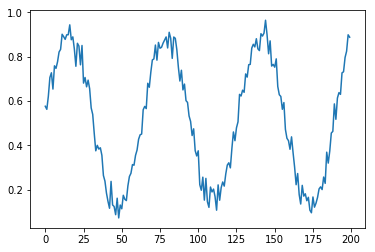

In [2]:
N=int(1e4) # FIXME 1e5

# Try dataset from https://stats.stackexchange.com/questions/190148/autoencoder-pca-tensorflow?rq=1
from sklearn.preprocessing import scale
def data1(n_samples:int=2000):
    n_features=5
    # n_samples, n_features = 2000, 5
    # X = np.random.uniform(0, 1, (n_samples, n_features))
    X = np.zeros((n_samples,n_features))
    
    sigma = 0.1
    xt=np.arange(0,n_samples/10,1/10)
    X[:,0] = .5 + .5*np.sin(1*xt) + np.random.normal(0, sigma, N) +1 # first sine wave
    X[:,1] = .5 + .5*np.sin(2*xt) + np.random.normal(0, sigma, N) +1 # second sine wave
    X[:,2] = 1*np.cos(1*xt) + np.random.normal(0, sigma, N) +1 # lagged version of first sine wave
    X[:,3] = X[:,1]*X[:, 2] # some non-linear relations between lagged and other
    X[:,4] = X[:,1]**2 * X[:, 0]**3 # some non-linear relations between 2 sines
    # auto-encoders need [0-1] range data
    # If PCA input is (mean=0,std=1) and AE is [0-1], MSE is incomparable
    # X = scale(X)
    X = utils.myNorm3(X)
    return X

def data2(n_samples:int=2000):
    n_features=2
    # n_samples, n_features = 2000, 5
    # X = np.random.uniform(0, 1, (n_samples, n_features))
    X = np.zeros((n_samples,n_features), dtype=np.float64)
    sigma = 0.1
    xt=np.arange(0,n_samples/10,1/10)
    X[:,0] = np.random.normal(0, sigma, N) +1 # first sine wave
    X[:,1] = -1*X[:,0]
    X = utils.myNorm3(X)
    return X

def data3(n_samples:int=2000):
    n_features=1
    # n_samples, n_features = 2000, 5
    # X = np.random.uniform(0, 1, (n_samples, n_features))
    X = np.zeros((n_samples,n_features))
    
    sigma = 0.1
    xt=np.arange(0,n_samples/10,1/10)
    X[:,0] = np.sin(1*xt) + np.random.normal(0, sigma, N)
    X = utils.myNorm3(X)
    return X

#X = data1(N)
#X = data2(N)
X = data3(N)

print(X.shape)
print('X',X[0:10,:])

utils.myPlot(X,2)

## Try PCA

PCA
n_components =  1
err pca =  3.06170278861e-16
Explained variance ratio (cumsum) [ 1.]


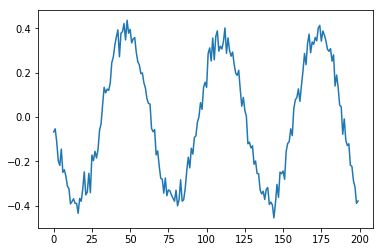

In [3]:
N_epochs = 25
n_c_i = 1#2#5
print("PCA")
pca = PCA(n_components=n_c_i, random_state=888, svd_solver = 'full')
X_pca = pca.fit_transform(X)
# print("X_pca_0",X_pca_0[0:10,:])
# print("")
# print("Explained variance ratio (cumsum)", np.cumsum(pca.explained_variance_ratio_))
# print("")
print("n_components = ",n_c_i)
utils.pca_err(X, X_pca)
print("Explained variance ratio (cumsum)", np.cumsum(pca.explained_variance_ratio_))
# plot
utils.myPlot(X_pca,2)


## Vanilla AE

autoencoder
n_components =  15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                30        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 46
Trainable params: 46
Non-trainable params: 0
_________________________________________________________________


/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1977: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


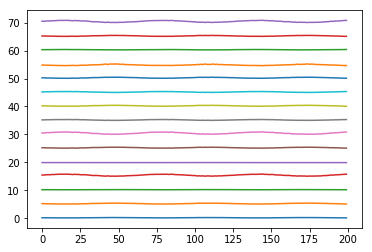

AE1 mse =  0.0268036873553


In [4]:
print("autoencoder")
N_epochs = 200
n_c_i = 15 # [7,10,15,20,25]: # 'mle'
print("n_components = ",n_c_i)

vanilla_ae, vanilla_enc = utils.buildNetwork(X.shape[1], encoding_dim_ae = n_c_i)
vanilla_ae.summary()
X_rec = utils.ae_fit_encode_plot_mse(X, vanilla_ae, vanilla_enc, N_epochs, verbose=0)
print("AE1 mse = ", utils.mse(X, X_rec))

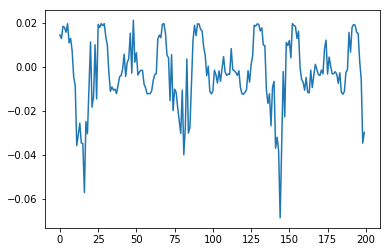

In [5]:
utils.myPlot(X_rec-X,2)

## Deep AE

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                30        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 15)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 48        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 3)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 4         
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________


/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1977: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train on 8000 samples, validate on 2000 samples
Epoch 1/200
0s - loss: 0.0521 - val_loss: 0.0480
Epoch 2/200
0s - loss: 0.0445 - val_loss: 0.0413
Epoch 3/200
0s - loss: 0.0381 - val_loss: 0.0350
Epoch 4/200
0s - loss: 0.0320 - val_loss: 0.0290
Epoch 5/200
0s - loss: 0.0262 - val_loss: 0.0234
Epoch 6/200
0s - loss: 0.0208 - val_loss: 0.0182
Epoch 7/200
0s - loss: 0.0158 - val_loss: 0.0135
Epoch 8/200
0s - loss: 0.0114 - val_loss: 0.0094
Epoch 9/200
0s - loss: 0.0077 - val_loss: 0.0062
Epoch 10/200
0s - loss: 0.0050 - val_loss: 0.0041
Epoch 11/200
0s - loss: 0.0033 - val_loss: 0.0029
Epoch 12/200
0s - loss: 0.0024 - val_loss: 0.0021
Epoch 13/200
0s - loss: 0.0018 - val_loss: 0.0017
Epoch 14/200
0s - loss: 0.0015 - val_loss: 0.0013
Epoch 15/200
0s - loss: 0.0012 - val_loss: 0.0011
Epoch 16/200
0s - loss: 9.8475e-04 - val_loss: 9.4039e-04
Epoch 17/200
0s - loss: 8.3538e-04 - val_loss: 7.9844e-04
Epoch 18/200
0s - loss: 7.2155e-04 - val_loss: 6.9951e-04
Epoch 19/200
0s - loss: 6.2516e-04 - 

0s - loss: 1.9004e-05 - val_loss: 2.4905e-05
Epoch 145/200
0s - loss: 1.9248e-05 - val_loss: 1.6080e-05
Epoch 146/200
0s - loss: 1.8677e-05 - val_loss: 1.5340e-05
Epoch 147/200
0s - loss: 1.9110e-05 - val_loss: 1.6877e-05
Epoch 148/200
0s - loss: 1.8810e-05 - val_loss: 2.5638e-05
Epoch 149/200
0s - loss: 1.9376e-05 - val_loss: 1.5189e-05
Epoch 150/200
0s - loss: 1.8514e-05 - val_loss: 1.6768e-05
Epoch 151/200
0s - loss: 1.8881e-05 - val_loss: 2.1969e-05
Epoch 152/200
0s - loss: 1.8422e-05 - val_loss: 2.2759e-05
Epoch 153/200
0s - loss: 1.8666e-05 - val_loss: 2.6038e-05
Epoch 154/200
0s - loss: 1.8696e-05 - val_loss: 1.7810e-05
Epoch 155/200
0s - loss: 1.9672e-05 - val_loss: 2.5867e-05
Epoch 156/200
0s - loss: 1.8976e-05 - val_loss: 2.2322e-05
Epoch 157/200
0s - loss: 1.8778e-05 - val_loss: 1.6132e-05
Epoch 158/200
0s - loss: 1.9163e-05 - val_loss: 1.8079e-05
Epoch 159/200
0s - loss: 1.8237e-05 - val_loss: 2.5507e-05
Epoch 160/200
0s - loss: 1.9224e-05 - val_loss: 2.1259e-05
Epoch 161/2

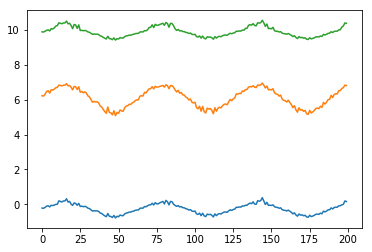

AE2 mse =  0.00660645443039


In [6]:
# https://stackoverflow.com/a/43549608/4126114
#tensorboard = keras.callbacks.TensorBoard(log_dir='/tmp/tb/r0-AE-15-3-nonsymmetric',
#                 histogram_freq=10, 
#                 write_graph=True, 
#                 write_images=False)

deep_ae, deep_enc = utils.buildNetwork2_deep(X.shape[1], enc_dim1 = n_c_i, enc_dim2 = 3, symmetric=False)
deep_ae.summary()
X_rec = utils.ae_fit_encode_plot_mse(X, deep_ae, deep_enc, N_epochs, verbose=2)#, callbacks=[tensorboard])
print("AE2 mse = ", utils.mse(X, X_rec))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 15)                30        
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 15)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 48        
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 3)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 15)                60        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 16        
Total para

/home/ubuntu/.local/share/virtualenvs/G2ML/lib/python3.5/site-packages/sklearn/model_selection/_split.py:1977: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


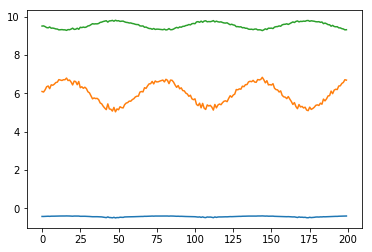

AE2 mse =  0.0270485410559


In [7]:
# https://stackoverflow.com/a/43549608/4126114
#tensorboard = keras.callbacks.TensorBoard(log_dir='/tmp/tb/r0-AE-15-3-nonsymmetric',
#                 histogram_freq=10, 
#                 write_graph=True, 
#                 write_images=False)

deep_ae, deep_enc = utils.buildNetwork2_deep(X.shape[1], enc_dim1 = n_c_i, enc_dim2 = 3, symmetric=True)
deep_ae.summary()
X_rec = utils.ae_fit_encode_plot_mse(X, deep_ae, deep_enc, N_epochs, verbose=0)#, callbacks=[tensorboard])
print("AE2 mse = ", utils.mse(X, X_rec))

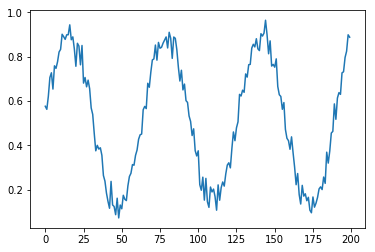

In [8]:
utils.myPlot(X,2)

## LSTM-based autoencoder

In [9]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM
from keras.layers import RepeatVector, TimeDistributed, Input
from keras.layers.advanced_activations import LeakyReLU #, PReLU

in_neurons = X.shape[1]
print(in_neurons)
out_neurons = in_neurons
hidden_neurons = 150 # 25 # FIXME
# set below by judging by the crescents of the sin and cos in data generation
# look back = 50 with hidden neurons = 25 => MSE = 0.008
# look back = 100 with hidden neurons = 25 => MSE = 0.05
# ditto with enc_dim = 3 => MSE = ?
# BUT PERHAPS MEASURING WITH MSE LIKE THIS IS NOT GOOD
# BECAUSE I SEE THAT THE PREDICTED SIGNAL IS LAGGED
# I PROBABLY NEED SOME ALIGNMENT BEFORE CALCULATING MSE
#
# Edit: the predicted signal is also a cleaned version (without the noise)
#       The MSE in this case should be computed wrt the clean signal?
look_back = 500 # 100 # FIXME
enc_dim = None #3 # FIXME None

lstm_ae = Sequential()

# lstm_ae.add(Input(shape=(look_back, in_neurons))

# combined from Simple_LSTM_keras_2 and LSTM book, chap 9, seq2seq
lstm_ae.add(LSTM(hidden_neurons, return_sequences=False, input_shape=(None, in_neurons)))

# encoder layer
if enc_dim is not None:
    lstm_ae.add(Dense(enc_dim, activation='linear'))
    lstm_ae.add(LeakyReLU(alpha=.3))

lstm_ae.add(RepeatVector(look_back))
lstm_ae.add(LSTM(hidden_neurons, return_sequences=True))
lstm_ae.add(TimeDistributed(Dense(out_neurons, activation='linear')))

lstm_ae.compile(loss="mean_squared_error", optimizer="rmsprop")

lstm_ae.summary()


1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 500, 150)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 500, 150)          180600    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 500, 1)            151       
Total params: 271,951
Trainable params: 271,951
Non-trainable params: 0
_________________________________________________________________


(10000, 1) (8501, 500, 1) (501, 500, 1)


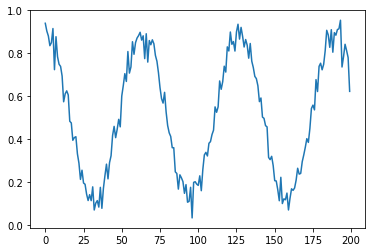

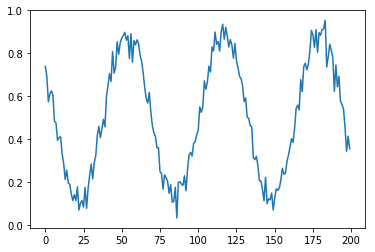

In [10]:
from utils2 import train_test_split
(X_train), (X_test) = train_test_split(X, test_size=0.1, look_back=look_back)  # retrieve data
print(X.shape, X_train.shape, X_test.shape)

#x2 = [100+x for x in range(len(y_test))]
#print(len(x2),x2)

utils.myPlot(X_test[0],2)
utils.myPlot(X_test[10],2)

In [11]:
# https://stackoverflow.com/a/43549608/4126114
tensorboard = keras.callbacks.TensorBoard(log_dir='/tmp/tb/r3-lstm-150',
                 histogram_freq=10, 
                 write_graph=True, 
                 write_images=False)


epochs=10 # FIXME # 10
print(X_train.shape)
lstm_ae.fit(X_train, X_train, batch_size=450, epochs=epochs, validation_split=0.2, callbacks=[tensorboard])

(8501, 500, 1)
Train on 6800 samples, validate on 1701 samples
INFO:tensorflow:Summary name lstm_1/kernel:0 is illegal; using lstm_1/kernel_0 instead.
INFO:tensorflow:Summary name lstm_1/recurrent_kernel:0 is illegal; using lstm_1/recurrent_kernel_0 instead.
INFO:tensorflow:Summary name lstm_1/bias:0 is illegal; using lstm_1/bias_0 instead.
INFO:tensorflow:Summary name lstm_2/kernel:0 is illegal; using lstm_2/kernel_0 instead.
INFO:tensorflow:Summary name lstm_2/recurrent_kernel:0 is illegal; using lstm_2/recurrent_kernel_0 instead.
INFO:tensorflow:Summary name lstm_2/bias:0 is illegal; using lstm_2/bias_0 instead.
INFO:tensorflow:Summary name time_distributed_1/kernel:0 is illegal; using time_distributed_1/kernel_0 instead.
INFO:tensorflow:Summary name time_distributed_1/bias:0 is illegal; using time_distributed_1/bias_0 instead.
Epoch 1/10
6800/6800 [==============================] - 275s - loss: 0.1202 - val_loss: 0.0949
Epoch 2/10
6800/6800 [==============================] - 248s -

KeyboardInterrupt: 

1 (501, 500, 1) (501, 500, 1) 0.733188538466


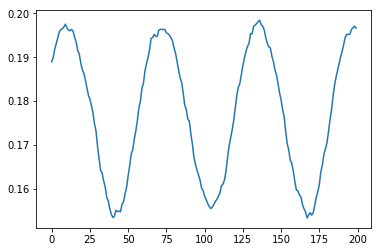

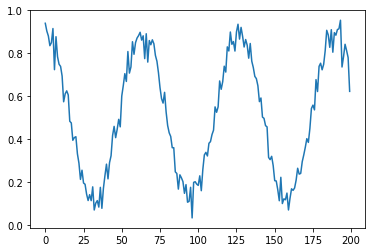

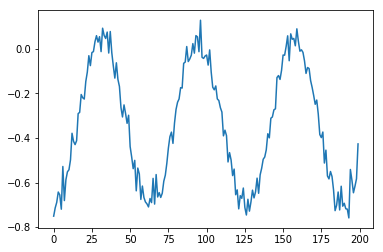

In [12]:
predicted = lstm_ae.predict(X_test)  
rmse = utils.mse(X_test[:,0,:], predicted[:,0,:])
print(1, X_test.shape, predicted.shape, rmse)

#utils.myPlot(predicted[:,0,:],2)
#utils.myPlot(X_test[:,0,:],2)
utils.myPlot(predicted[:,0,:],2)
utils.myPlot(X_test[:,0,:],2)
utils.myPlot(predicted[:,0,:]-X_test[:,0,:],2)

In [ ]:
print('-'*10)
from keras.models import Model
lstm_enc = Model(inputs=lstm_ae.input, outputs=lstm_ae.layers[2].output)
lstm_enc.compile(loss="mean_squared_error", optimizer="rmsprop")
lstm_enc.summary()

X_enc = lstm_enc.predict(X_test)

In [ ]:
print(X_test.shape, X_enc.shape)
utils.myPlot(X_enc[:,0,:],2) # should not need utils.myNorm3